In [6]:
# !pip install yfinance

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,6]
import datetime
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [81]:
stock = 'TSLA'
start = datetime.datetime(2023, 8, 15)
end = datetime.datetime(2024, 8, 19)
tsla_close = yf.download(stock, start=start, end=end, interval='1d')['Close']

[*********************100%%**********************]  1 of 1 completed


In [82]:
tsla_close.head()

Date
2023-08-15    232.960007
2023-08-16    225.600006
2023-08-17    219.220001
2023-08-18    215.490005
2023-08-21    231.279999
Name: Close, dtype: float64

In [71]:
tsla_close = pd.DataFrame(tsla_close)

In [83]:
tsla_close.describe()

count    254.000000
mean     212.045512
std       33.136624
min      142.050003
25%      180.034996
50%      210.930000
75%      242.279999
max      276.040009
Name: Close, dtype: float64

In [84]:
tsla = yf.download(stock, start=start, end=end, interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [85]:
tsla.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [86]:
tsla['Volume'].tail(25)

Date
2024-07-15    146912900
2024-07-16    126332500
2024-07-17    115584800
2024-07-18    110869000
2024-07-19     87403900
2024-07-22    101225400
2024-07-23    111928200
2024-07-24    167942900
2024-07-25    100636500
2024-07-26     94604100
2024-07-29    129201800
2024-07-30    100560300
2024-07-31     67497000
2024-08-01     83861900
2024-08-02     82880100
2024-08-05    100308800
2024-08-06     73783900
2024-08-07     71159800
2024-08-08     65033900
2024-08-09     58648300
2024-08-12     64044900
2024-08-13     76247400
2024-08-14     70250000
2024-08-15     89848500
2024-08-16     88646900
Name: Volume, dtype: int64

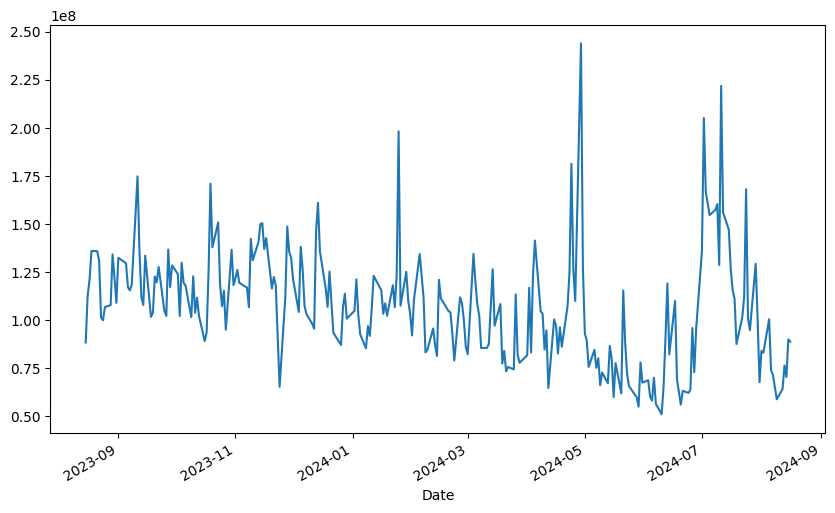

In [87]:
tsla['Volume'].plot()
plt.show()

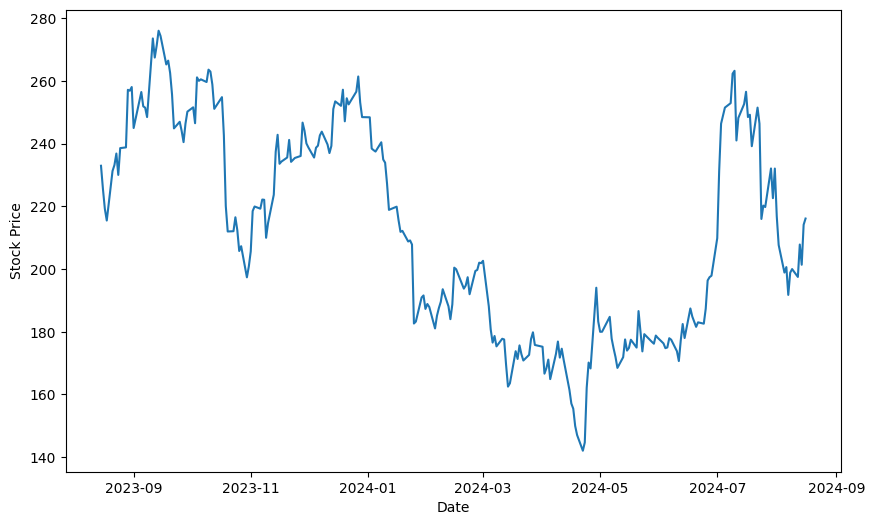

In [88]:
plt.plot(tsla_close)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

## Trend, Seasonality, Cyclicity and Noise

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose

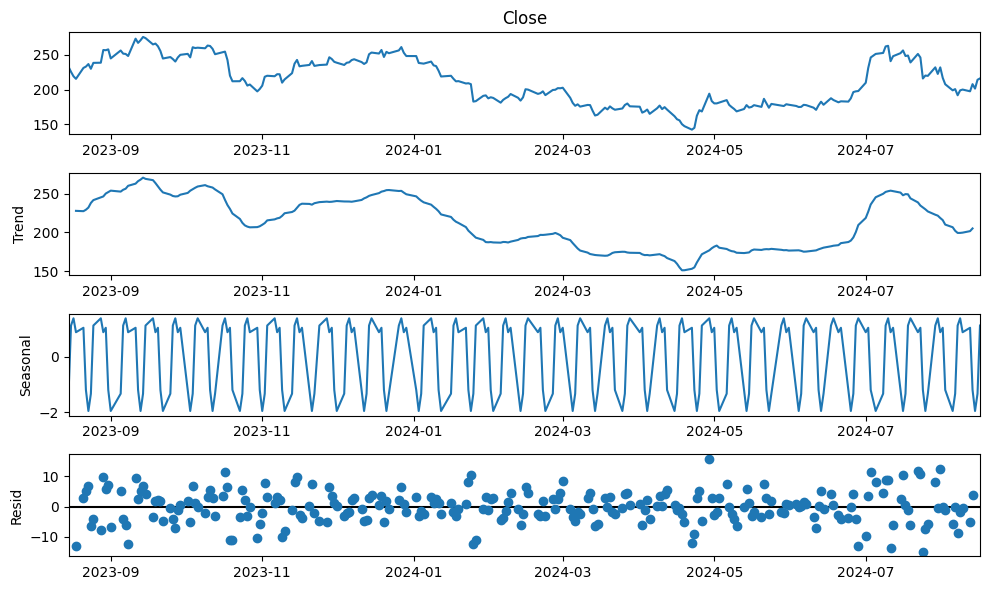

In [90]:
decomposition = seasonal_decompose(tsla_close, model='additive', period=7)
decomposition.plot()
plt.show()

## Missing Values

In [91]:
tsla_close = pd.DataFrame(tsla_close)

In [92]:
tsla_close.isnull().sum()

Close    0
dtype: int64

In [93]:
tsla_close.iloc[-5] = np.NaN      # putting a missing value in the dataframe artificially

In [94]:
tsla_close.tail()

,Close
Date,
2024-08-12,NaN
2024-08-13,207.830002
2024-08-14,201.380005
2024-08-15,214.139999
2024-08-16,216.119995


In [95]:
tsla_close['tsla_close_ffill'] = tsla_close['Close'].ffill()
tsla_close['tsla_close_ffill'].tail(6)

Date
2024-08-09    200.000000
2024-08-12    200.000000
2024-08-13    207.830002
2024-08-14    201.380005
2024-08-15    214.139999
2024-08-16    216.119995
Name: tsla_close_ffill, dtype: float64

Forward fill fills the missing value with the value from the (t-1) i.e. previous record.

In [96]:
tsla_close['tsla_close_bfill'] = tsla_close['Close'].bfill()
tsla_close['tsla_close_bfill'].tail()

Date
2024-08-12    207.830002
2024-08-13    207.830002
2024-08-14    201.380005
2024-08-15    214.139999
2024-08-16    216.119995
Name: tsla_close_bfill, dtype: float64

Backward fill fills the missing value with the value from the (t+1) i.e. next record.

## Interpolation

In [97]:
from scipy import interpolate

In [98]:
tsla_close['tsla_close_interpolate'] = tsla_close['Close'].interpolate(option='time')

In [99]:
tsla_close.tail()

,Close,tsla_close_ffill,tsla_close_bfill,tsla_close_interpolate
Date,,,,
2024-08-12,NaN,200.000000,207.830002,203.915001
2024-08-13,207.830002,207.830002,207.830002,207.830002
2024-08-14,201.380005,201.380005,201.380005,201.380005
2024-08-15,214.139999,214.139999,214.139999,214.139999
2024-08-16,216.119995,216.119995,216.119995,216.119995


## Outlier Detection using Isolation Forest (machine learning algorithm used for anomaly detection)

In [38]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [41]:
scaler = StandardScaler()
tsla_scaled = scaler.fit_transform(tsla_close['tsla_close_interpolate'].values.reshape(-1,1))
tsla_scaled = pd.DataFrame(tsla_scaled)

In [42]:
tsla_scaled.head()

,0
0,-2.575642
1,-2.433600
2,-2.518210
3,-2.448471
4,-2.276431


In [43]:
outlier_fraction = 0.01
isolation_model = IsolationForest(contamination=outlier_fraction)
isolation_model.fit(tsla_scaled)
tsla_close['anomaly'] = isolation_model.predict(tsla_scaled)

In [44]:
tsla_close['anomaly'].value_counts()

 1    392
-1      4
Name: anomaly, dtype: int64

## Generation of White Noise artificially

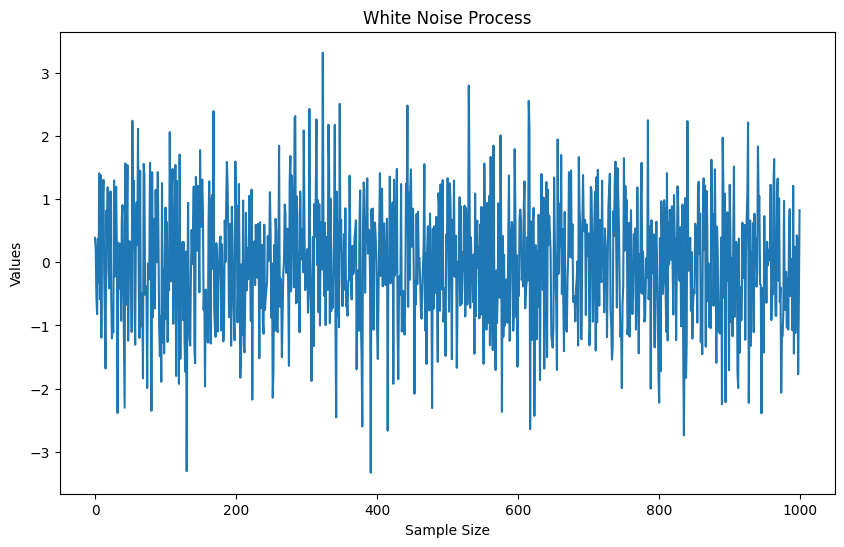

In [46]:
mu = 0
std = 1
sample_size = 1000
wn = np.random.normal(mu, std, sample_size)
plt.plot(wn)
plt.title('White Noise Process')
plt.xlabel('Sample Size')
plt.ylabel('Values')
plt.show()

#### White noise can be removed using a moving average filter.

## Random Walk

In [112]:
def randomwalk(steps):
    x,y = 0, 0
    time_steps = np.arange(steps+1)
    positions = [y]
    random_directions = ['Up', 'Down']
    for i in range(1, steps+1):
        step = np.random.choice(random_directions)
        if step == 'Up':
            y += 1
        elif step == 'Down':
            y -= 1
        positions.append(y)
    return time_steps, positions

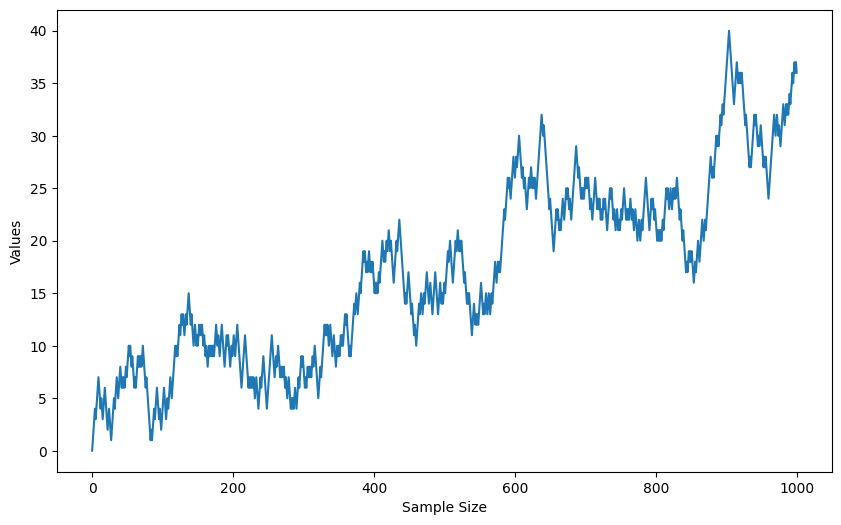

In [113]:
steps = 1000
time_steps, positions = randomwalk(steps)
plt.plot(time_steps, positions)
plt.xlabel('Sample Size')
plt.ylabel('Values')
plt.show()

## Detecting and handling Stationarity in Data

In [115]:
tsla_close = yf.download(stock, start=start, end=end, interval='1d')['Close']
tsla_close.head()

[*********************100%%**********************]  1 of 1 completed


Date
2023-08-15    232.960007
2023-08-16    225.600006
2023-08-17    219.220001
2023-08-18    215.490005
2023-08-21    231.279999
Name: Close, dtype: float64

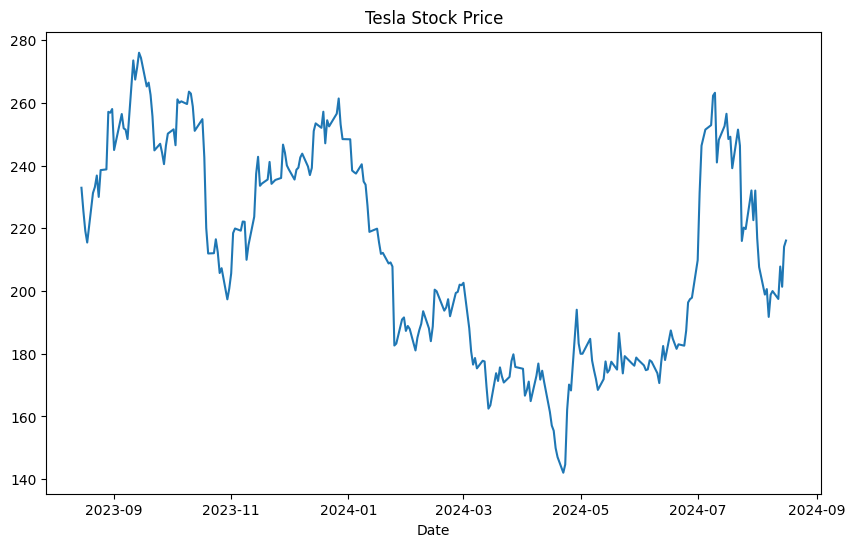

In [116]:
plt.plot(tsla_close)
plt.xlabel('Date')
plt.title('Tesla Stock Price')
plt.show()

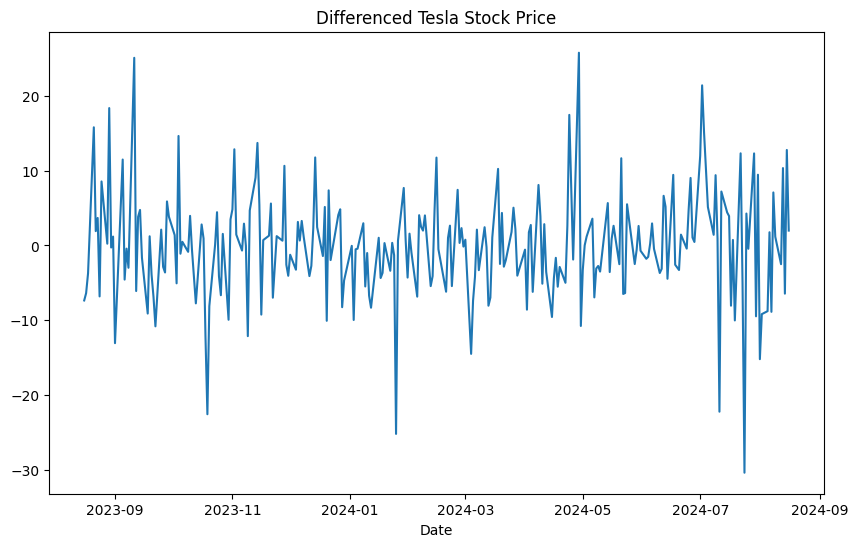

In [118]:
diff_tsla = tsla_close.diff()
plt.plot(diff_tsla)
plt.xlabel('Date')
plt.title('Differenced Tesla Stock Price')
plt.show()

## AutoCorrelation Function

In [133]:
import statsmodels as sm

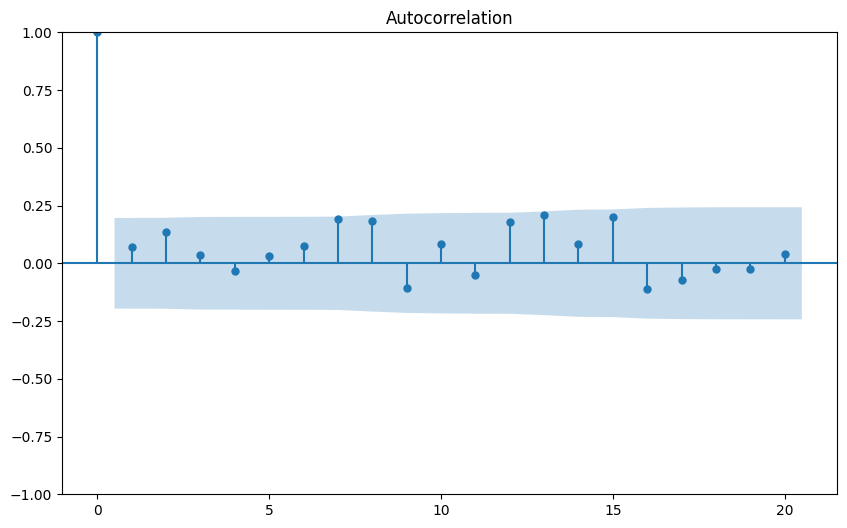

In [136]:
sm.graphics.tsaplots.plot_acf(diff_tsla);

## Partial AutoCorrelation Function

In [123]:
import statsmodels as sm

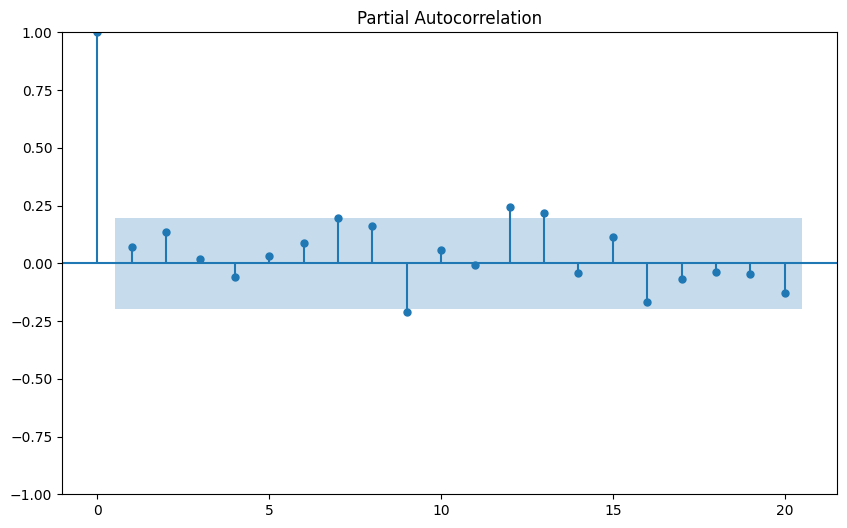

In [137]:
sm.graphics.tsaplots.plot_pacf(diff_tsla);

## Test for Stationarity

## ADF Test

In [139]:
from statsmodels.tsa.stattools import adfuller

In [142]:
adf_res = adfuller(diff_tsla)

In [145]:
print(adf_res)

(-9.29857475976558, 1.1285451053950827e-15, 0, 99, {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}, 248.09069833477784)


In [146]:
test_stat, p_val, n_lags, n_obs, crit_val, _ = adfuller(diff_tsla)

In [147]:
test_stat

-9.29857475976558

In [148]:
p_val

1.1285451053950827e-15

In [149]:
n_lags

0

In [150]:
n_obs

99

In [151]:
crit_val

{'1%': -3.498198082189098,
 '5%': -2.891208211860468,
 '10%': -2.5825959973472097}

Since p value > critical value, hence we fail to reject the null hypothesis. This the data is non-stationary (H0 null hypothesis of ADF states: Data is non-stationary).

In [152]:
from statsmodels.tsa.stattools import kpss

In [153]:
kpss_res = kpss(diff_tsla)
print(kpss_res)

(0.3564804766840454, 0.09591358763618732, 3, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


In [154]:
statistics, p_value, n_lags, critical_value = kpss(diff_tsla)

In [155]:
statistics

0.3564804766840454

In [156]:
p_value

0.09591358763618732

In [157]:
n_lags

3

In [158]:
critical_value

{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

Since p-value < critica value thus we reject the null hypothesis. Null hypotheis H0 for KPSS Test says the data is stationary. Thus according to the KPSS Test here, the data is non-stationary. Both ADF and KPSS gives the same result that the data is non-stationary.

## Simple Moving Average

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Xt = Xt + 0.7*Zt-1 + 0.3Zt-2

t-1 and t-2 are subscripts

In [162]:
noise = np.random.normal(size = (1000,))

In [164]:
noise[:10]

array([ 1.8831507 , -1.34775906, -1.270485  ,  0.96939671, -1.17312341,
        1.94362119, -0.41361898, -0.74745481,  1.92294203,  1.48051479])

In [165]:
ma_2_process = np.full(len(noise)-2, np.nan)

In [166]:
ma_2_process.shape

(998,)

In [167]:
ma_2_process[:10]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [169]:
for idx, time_step in enumerate(range(2, len(noise))):
    ma_2_process[idx] = noise[time_step] + 0.7*noise[time_step-1] + 0.3*noise[time_step-2]

In [170]:
ma_2_process.shape

(998,)

In [171]:
ma_2_process[:10]

array([-1.64897113, -0.32427051, -0.87569121,  1.41325381,  0.59497883,
       -0.45390174,  1.27563796,  2.60233777,  3.48080192,  2.65749037])

In [172]:
index = pd.date_range(start='1/1/2021', periods=len(ma_2_process), freq='d')

In [173]:
df_ma_2 = pd.DataFrame(data=ma_2_process, index=index, columns=['Value'])

In [174]:
df_ma_2.head()

,Value
2021-01-01,-1.648971
2021-01-02,-0.324271
2021-01-03,-0.875691
2021-01-04,1.413254
2021-01-05,0.594979


In [176]:
from statsmodels.graphics.tsaplots import plot_acf

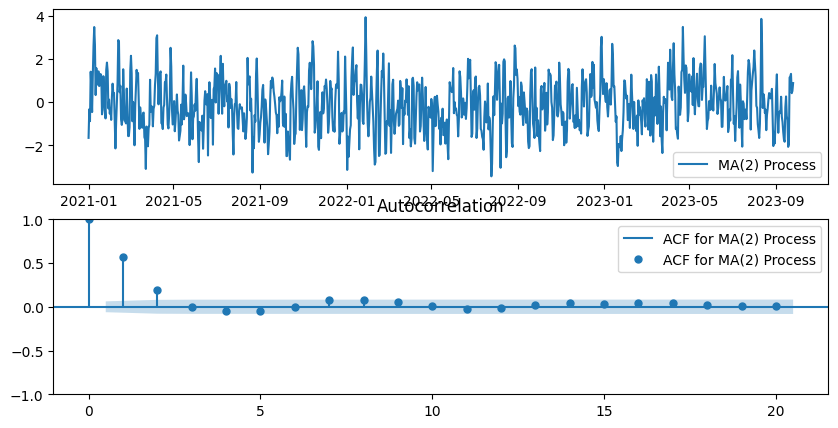

In [180]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(211)
ax1.plot(df_ma_2, label='MA(2) Process')
ax1.legend()

ax2 = plt.subplot(212)
plot_acf(df_ma_2, ax=ax2, label='ACF for MA(2) Process', lags=20)
ax2.legend()

plt.tight_layout
plt.show()

## ARMA Model

In [181]:
from statsmodels.tsa.arima.model import ARIMA

In [185]:
arma_model = ARIMA(diff_tsla, order=(8, 0, 8))
arma_results = arma_model.fit()